In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [2]:
#Reading data - Source - https://datahack.analyticsvidhya.com/contest/black-friday/
df = pd.read_csv("Retail Sales.csv")
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [3]:
df.shape

(550068, 12)

# Exploratory Data Analysis

In [4]:
df.User_ID.nunique()

5891

In [5]:
df.Product_ID.nunique()

3631

Data (550068 records) has only 5891 unique users and 3631 which means users and Products are getting repeated. User_ID and Product_ID themselves do not provide much information but since these are related to consumers and Products we will have to relate these to Purchase amount instead of using these just as IDs. We can replace User_IDs and Product_IDs by mean or median of the Purchases. This should establish relation between the Product and Purchase value and User and Purchase value.

In [6]:
df["Age"].unique()

array(['0-17', '55+', '26-35', '46-50', '51-55', '36-45', '18-25'],
      dtype=object)

Age is clearly Ordinal variable but the data has it in the form of string. We can encode this by numbers in ascending order.

In [7]:
df["Occupation"].unique()

array([10, 16, 15,  7, 20,  9,  1, 12, 17,  0,  3,  4, 11,  8, 19,  2, 18,
        5, 14, 13,  6], dtype=int64)

Occupation is already encoded

In [8]:
df["City_Category"].nunique()

3

In [9]:
df["Stay_In_Current_City_Years"].unique()

array(['2', '4+', '3', '1', '0'], dtype=object)

Similar to Age, Stay_In_Current_City_Years is ordinal variable in string format, we can ecode it with increasing numbers

In [10]:
df["Marital_Status"].nunique()

2

Since Product_Category_2 and Product_Category_3 are having NaaN values one option could be to use 0 to indicate missing value. For this we first need to check if any of the categories (including Product_Category_1) has 0 as value of not. If yes then we can use 0 to indicate missing value. Let's check all three categories for zero values.

In [11]:
df[df["Product_Category_1"] == 0].count()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      0
dtype: int64

In [12]:
df[df["Product_Category_2"] == 0].count()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      0
dtype: int64

In [13]:
df[df["Product_Category_3"] == 0].count()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      0
dtype: int64

We got confirmation that 0 is not used in any of the Product category. So we can use 0 to indicate missing values in Product_Category_2 and Product_Category_3

Let's summarize Data endoding strategy

User_ID - Repalce User_ID by median of the Purchase vaule

Product_ID - Repalce Product_ID by median of the Purchase vaule

Gender - One hot encoding -0/1

Age - Manually encode the range in ordinal wa.

Occupation - Leave it as it is 

Catgory of the City - One hot encoding. Ordinal can also be used but we are not sure if there is any order based on standard of living

Stay_In_Current_City_Years -  Manually encode the range in ordinal way.

Marital Status - Leave it as it is

Product_Category_2 and Product_Category_3 - replace NaaN values by 0. This is because there are no 0 values in any of the 
Product Categories

In [14]:
#Endoding Gender
df["Gender"] = df["Gender"].map({'F':0,'M':1})
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,0,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,0,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,0,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,0,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,1,55+,16,C,4+,0,8,NaN,NaN,7969


In [15]:
#Encoding Age
df["Age"] = df["Age"].map({'0-17':1, '55+':7, '26-35':3, '46-50':5, '51-55':6, '36-45':4, '18-25':2})

In [16]:
#Encoding Stay_In_Current_City_Years
df["Stay_In_Current_City_Years"] = df["Stay_In_Current_City_Years"].map({'0':0,'1':1,'2':2,'3':3,'4+':4})

In [17]:
#One hot encoding City_Category
dummy = pd.get_dummies(df["City_Category"])
df= pd.concat([df, dummy],axis = 1)
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,A,B,C
0,1000001,P00069042,0,1,10,A,2,0,3,NaN,NaN,8370,1,0,0
1,1000001,P00248942,0,1,10,A,2,0,1,6.0,14.0,15200,1,0,0
2,1000001,P00087842,0,1,10,A,2,0,12,NaN,NaN,1422,1,0,0
3,1000001,P00085442,0,1,10,A,2,0,12,14.0,NaN,1057,1,0,0
4,1000002,P00285442,1,7,16,C,4,0,8,NaN,NaN,7969,0,0,1


In [18]:
#Filling missing values of Product_Category_2 and Product_Category_3
df["Product_Category_2"]= df["Product_Category_2"].fillna(0)
df["Product_Category_3"]=df["Product_Category_3"].fillna(0)

In [19]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,A,B,C
0,1000001,P00069042,0,1,10,A,2,0,3,0.0,0.0,8370,1,0,0
1,1000001,P00248942,0,1,10,A,2,0,1,6.0,14.0,15200,1,0,0
2,1000001,P00087842,0,1,10,A,2,0,12,0.0,0.0,1422,1,0,0
3,1000001,P00085442,0,1,10,A,2,0,12,14.0,0.0,1057,1,0,0
4,1000002,P00285442,1,7,16,C,4,0,8,0.0,0.0,7969,0,0,1


In [20]:
#Dropping City_Category as we have one hot encoded it
df = df.drop(columns =["City_Category"])

Let's analyze the impact of each feature on Purchase one by one. Let's start with getting more insights into Purchase itself.

In [21]:
df['Purchase'].describe()

count    550068.000000
mean       9263.968713
std        5023.065394
min          12.000000
25%        5823.000000
50%        8047.000000
75%       12054.000000
max       23961.000000
Name: Purchase, dtype: float64

Purchase has a wide range from 12 to 23961. 25th, 50th and 75th percentile points are also far from each other. We will need to investigate further which features are correponding to low purchase value and which ones are resulting in higher purchase value.

In [22]:
#Checking how Age is impacting the purchase value
df.groupby('Age').Purchase.median()

Age
1    7986.0
2    8027.0
3    8030.0
4    8061.0
5    8036.0
6    8130.0
7    8105.5
Name: Purchase, dtype: float64

Age seems to have some impact on the Purchase amount. It may not be very important feature but definately worth considering.

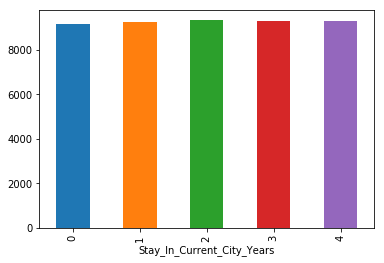

In [23]:
df.groupby('Stay_In_Current_City_Years').Purchase.mean().plot(kind = 'bar')

Stay_In_Current_City_Years does not have much impact on the Purchase value. Median Purchases of people staying in the city for different number of years are almost the same. However is there any relation between Stay_In_Current_City_Years and City Category ? Let's check.

In [24]:
df.groupby('A').Stay_In_Current_City_Years.median()

A
0    2
1    2
Name: Stay_In_Current_City_Years, dtype: int64

In [25]:
df.groupby('B').Stay_In_Current_City_Years.median()

B
0    2
1    2
Name: Stay_In_Current_City_Years, dtype: int64

In [26]:
df.groupby('C').Stay_In_Current_City_Years.median()

C
0    2
1    2
Name: Stay_In_Current_City_Years, dtype: int64

Nope, Stay_In_Current_City_Years is not changing much with repect to Category of the City

In [27]:
df.groupby('Gender').Purchase.median()

Gender
0    7914
1    8098
Name: Purchase, dtype: int64

There is hardly any difference between Male and Female Purchase behavior. Gender does not seem to be a good feature.

In [29]:
df.groupby('Occupation').Purchase.median()

Occupation
0     8001.0
1     7966.0
2     7952.0
3     8008.0
4     8043.0
5     8080.0
6     8050.0
7     8069.0
8     8419.5
9     7886.0
10    8012.5
11    8041.5
12    8569.0
13    8090.5
14    8122.0
15    8513.0
16    8070.0
17    8635.0
18    7955.0
19    7840.0
20    7903.5
Name: Purchase, dtype: float64

Occupation is impacting the purchase amount. This may not be very important feature but definately worth considering.

In [30]:
df.groupby('Marital_Status').Purchase.median()

Marital_Status
0    8044
1    8051
Name: Purchase, dtype: int64

Marital status is not impacting the Purchase amount. Let's not consider Marital status as feature.

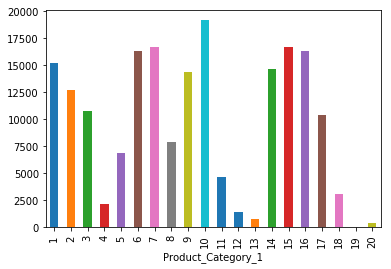

In [31]:
df.groupby('Product_Category_1').Purchase.median().plot(kind = 'bar')

Product_Category_1 seems to be a good feature. Product Category 10 is showing higher purchase amout. Looks like this category has pricier products.

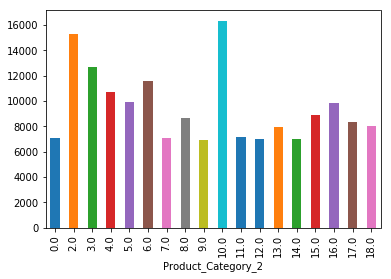

In [32]:
df.groupby('Product_Category_2').Purchase.median().plot(kind = 'bar')

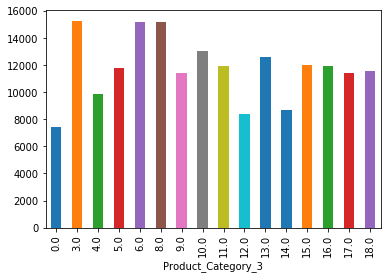

In [33]:
df.groupby('Product_Category_3').Purchase.median().plot(kind = 'bar')

Product_Category_2 and Product_Category_3 are also useful fetures. Since there are many missing values in these two categories let's analyze the difference in the median Purchase amount when the Products in these categories are bought versuses when the product in these categories are not bought.

In [34]:
df[(df['Product_Category_3'] == 0) & (df['Product_Category_2'] == 0)].Purchase.median()

7075.0

In [35]:
df[(df['Product_Category_3'] != 0) & (df['Product_Category_2'] != 0)].Purchase.median()

11756.0

Above analysis clearly shows that when Products in categories 2 & 3 are bought the median purchases are significantly higher. Thus, categories 2 & 3 are resulting in higher purchase amounts.

In [36]:
#Analyzing Category of City (A, B and C)
df.groupby('A').Purchase.median()

A
0    8092
1    7931
Name: Purchase, dtype: int64

In [37]:
df.groupby('B').Purchase.median()

B
0    8080
1    8005
Name: Purchase, dtype: int64

In [38]:
df.groupby('C').Purchase.median()

C
0    7975
1    8585
Name: Purchase, dtype: int64

A and B showing almost same results while City C is showing slightly higher Purchase amount. 

Earlier we saw that Product Category 2 and 3 imply higher Purchase amount. Does this also have to do with the City Category ? For example, can we say that the people living in Category C city are purchasing Products of Category 2 and 3 more than those living in Cities of Category A and B ? If this is not the case then Purchase amounts of Category C cities are more simply because of the higher prices and not because of the consumption behavior of People living in City C.Let's check.

In [39]:
df[df['C'] == 1 ].count()

User_ID                       171175
Product_ID                    171175
Gender                        171175
Age                           171175
Occupation                    171175
Stay_In_Current_City_Years    171175
Marital_Status                171175
Product_Category_1            171175
Product_Category_2            171175
Product_Category_3            171175
Purchase                      171175
A                             171175
B                             171175
C                             171175
dtype: int64

So there are total 171175 records from Cities of Category C

In [40]:
#Let's create a temporary feature to indicate if Product of category 2 or 3 is purchased 
def temp_feat(row):
    if (row['Product_Category_2'] == 0) & (row['Product_Category_3'] == 0):
        val= 1
    else:
        val = 0
    return val
    
df['Only_P1'] = df.apply(temp_feat, axis=1)

In [41]:
pd.crosstab(df['C'],df['Only_P1'])

Only_P1,0,1
C,,
0,256044,122849
1,120386,50789


In [42]:
pd.crosstab(df['A'],df['Only_P1'])

Only_P1,0,1
A,,
0,278069,124279
1,98361,49359


In [43]:
pd.crosstab(df['B'],df['Only_P1'])

Only_P1,0,1
B,,
0,218747,100148
1,157683,73490


Above analysis shows that out of the total records from cities of category C, 70% of the records have Purchases of either Product Category 2 or Product Category 3

For records from cities of category A and B the same percentage is 66% and 68%. Thus there is no significant difference but we can definately conclude following -

City Category and Product Categories are very important features

City Category C and Product Categories of 2 and 3 are implying higher purchase amounts

City Category are not just impacting the purchase amount but they are also have some implications on what category of Products are being purchased.


In [44]:
#Replacing User_ID by median of Purchase amounts
#Getting purchase amounts for each user ID
user_purchase = df.groupby('User_ID').Purchase.median()
#Creating a dictionary that will be passed in map function to create transformed feature in the original dataframe
dict_user = user_purchase.to_dict()
df["User"] = df["User_ID"].map(dict_user)
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,A,B,C,Only_P1,User
0,1000001,P00069042,0,1,10,2,0,3,0.0,0.0,8370,1,0,0,1,9946.0
1,1000001,P00248942,0,1,10,2,0,1,6.0,14.0,15200,1,0,0,0,9946.0
2,1000001,P00087842,0,1,10,2,0,12,0.0,0.0,1422,1,0,0,1,9946.0
3,1000001,P00085442,0,1,10,2,0,12,14.0,0.0,1057,1,0,0,0,9946.0
4,1000002,P00285442,1,7,16,4,0,8,0.0,0.0,7969,0,0,1,1,9899.0


In [45]:
#Replacing Product_ID by median of Purchase amounts
#Getting purchase amounts for each Product ID
product_purchase = df.groupby('Product_ID').Purchase.median()
#Creating a dictionary that will be passed in map function to create transformed feature in the original dataframe
dict_product = product_purchase.to_dict()
df["Product"] = df["Product_ID"].map(dict_product)
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,A,B,C,Only_P1,User,Product
0,1000001,P00069042,0,1,10,2,0,3,0.0,0.0,8370,1,0,0,1,9946.0,13265.0
1,1000001,P00248942,0,1,10,2,0,1,6.0,14.0,15200,1,0,0,0,9946.0,15812.0
2,1000001,P00087842,0,1,10,2,0,12,0.0,0.0,1422,1,0,0,1,9946.0,1378.0
3,1000001,P00085442,0,1,10,2,0,12,14.0,0.0,1057,1,0,0,0,9946.0,1423.0
4,1000002,P00285442,1,7,16,4,0,8,0.0,0.0,7969,0,0,1,1,9899.0,7925.0


In [46]:
df.drop(columns = ["User_ID","Product_ID",'Only_P1'],inplace = True)

In [47]:
df.head()

,Gender,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,A,B,C,User,Product
0,0,1,10,2,0,3,0.0,0.0,8370,1,0,0,9946.0,13265.0
1,0,1,10,2,0,1,6.0,14.0,15200,1,0,0,9946.0,15812.0
2,0,1,10,2,0,12,0.0,0.0,1422,1,0,0,9946.0,1378.0
3,0,1,10,2,0,12,14.0,0.0,1057,1,0,0,9946.0,1423.0
4,1,7,16,4,0,8,0.0,0.0,7969,0,0,1,9899.0,7925.0


In [48]:
#Creating X and Y dataframes
x= df.loc[:,["User","Product","A","B","C","Product_Category_1","Product_Category_2","Product_Category_3", "Age","Occupation"]]
y=df.loc[:,["Purchase"]]

In [49]:
x.head()

,User,Product,A,B,C,Product_Category_1,Product_Category_2,Product_Category_3,Age,Occupation
0,9946.0,13265.0,1,0,0,3,0.0,0.0,1,10
1,9946.0,15812.0,1,0,0,1,6.0,14.0,1,10
2,9946.0,1378.0,1,0,0,12,0.0,0.0,1,10
3,9946.0,1423.0,1,0,0,12,14.0,0.0,1,10
4,9899.0,7925.0,0,0,1,8,0.0,0.0,7,16


In [50]:
#Splitting Data in train and test
from sklearn.model_selection import train_test_split
x_train,x_test, y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 7)

In [53]:
#Quick Random Forest without Grid Search (Tried Grid Search but, I was getting memory error. Therefore manually tried various parameters)
RF = RandomForestRegressor(n_estimators= 400,max_depth = 300, max_features = 0.9,oob_score = True )

RF.fit(x_train, y_train.values.ravel())
#pred_RF_train = RF.predict(x_train)
pred_RF_test = RF.predict(x_test)

In [76]:
print("Quick Random Forest Performance")

print("Mean SE",mean_squared_error(pred_RF_test, y_test))
print("RMSE = ", np.sqrt(mean_squared_error(pred_RF_test, y_test)))



Quick Random Forest Performance
Mean SE 6607570.642176425
RMSE =  2570.5195276784857


In [75]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost.sklearn import XGBRegressor

xg = XGBRegressor(verbosity = 2,max_depth = 9, subsample = 0.9,n_estimators=350)
xg.fit(x_train, y_train)
pred_xg = xg.predict(x_test)
print("Mean SE",mean_squared_error(pred_xg, y_test))
print("RMSE = ", np.sqrt(mean_squared_error(pred_xg, y_test)))




Mean SE 6035410.191976288
RMSE =  2456.7071848261216


In [52]:
from sklearn.neighbors import KNeighborsRegressor
kn = KNeighborsRegressor(n_neighbors=10, p=2,algorithm = 'auto')
kn.fit(x_train, y_train)
pred_kn = kn.predict(x_test)
print("Mean SE",mean_squared_error(pred_kn, y_test))
print("RMSE = ", np.sqrt(mean_squared_error(pred_kn, y_test)))

Mean SE 6998623.974696494
RMSE =  2645.491253944434
